In [ ]:
#required packages:
!pip install --upgrade azureml-sdk[notebooks,automl]
!pip install sklearn
!pip install matplotlib
!pip install tensorflow
!pip install keras
!pip install pillow

In [1]:
from azureml.core import Workspace

Creating the workspace, if exists just connecting.

In [2]:

ws = Workspace.create(name='demows',
                      subscription_id='Your Subscription ID',    
                      resource_group='MLWSR',
                      create_resource_group=True,
                      location='westeurope', # or other supported Azure region  
                       exist_ok = True)

# see workspace details
ws.get_details()


{'id': '/subscriptions/757c4165-0823-49f7-9678-5a85fe5e17cc/resourceGroups/MLWSR/providers/Microsoft.MachineLearningServices/workspaces/demows',
 'name': 'demows',
 'location': 'westeurope',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'workspaceid': 'a701d726-5e1d-4549-9651-144a060112f9',
 'description': '',
 'friendlyName': 'demows',
 'creationTime': '2019-01-31T10:30:31.7037564+00:00',
 'containerRegistry': '/subscriptions/757c4165-0823-49f7-9678-5a85fe5e17cc/resourcegroups/mlwsr/providers/microsoft.containerregistry/registries/demowsacrqwcafahe',
 'keyVault': '/subscriptions/757c4165-0823-49f7-9678-5a85fe5e17cc/resourcegroups/mlwsr/providers/microsoft.keyvault/vaults/demowskeyvaultfehonicp',
 'applicationInsights': '/subscriptions/757c4165-0823-49f7-9678-5a85fe5e17cc/resourcegroups/mlwsr/providers/microsoft.insights/components/demowsinsightsvvfgwaet',
 'identityPrincipalId': '8b68ecb1-62b5-4ebb-8a55-86ef8cdefa26',
 'identityTenantId': '72f988bf-86f1-41af-91ab-2d7cd011d

Conencting to an existing one

In [ ]:
ws = Workspace(subscription_id='757c4165-0823-49f7-9678-5a85fe5e17cc', 
               resource_group='MLWSR', 
               workspace_name='demows', 
               auth=None, 
               _location='westeurope',
               _disable_service_check=False)



In [3]:
# see workspace details
ws.get_details()

{'id': '/subscriptions/757c4165-0823-49f7-9678-5a85fe5e17cc/resourceGroups/MLWSR/providers/Microsoft.MachineLearningServices/workspaces/demows',
 'name': 'demows',
 'location': 'westeurope',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'workspaceid': 'a701d726-5e1d-4549-9651-144a060112f9',
 'description': '',
 'friendlyName': 'demows',
 'creationTime': '2019-01-31T10:30:31.7037564+00:00',
 'containerRegistry': '/subscriptions/757c4165-0823-49f7-9678-5a85fe5e17cc/resourcegroups/mlwsr/providers/microsoft.containerregistry/registries/demowsacrqwcafahe',
 'keyVault': '/subscriptions/757c4165-0823-49f7-9678-5a85fe5e17cc/resourcegroups/mlwsr/providers/microsoft.keyvault/vaults/demowskeyvaultfehonicp',
 'applicationInsights': '/subscriptions/757c4165-0823-49f7-9678-5a85fe5e17cc/resourcegroups/mlwsr/providers/microsoft.insights/components/demowsinsightsvvfgwaet',
 'identityPrincipalId': '8b68ecb1-62b5-4ebb-8a55-86ef8cdefa26',
 'identityTenantId': '72f988bf-86f1-41af-91ab-2d7cd011d

In [4]:
print(ws.name, ws.location, ws.resource_group, sep = '\t')

demows	westeurope	MLWSR


Create the experiment

In [5]:
from azureml.core import Experiment

In [6]:
experiment_name = 'GEAR-EXP'
exp = Experiment(workspace=ws, name=experiment_name)

Create new Azure ML Compute Target Cluster

In [7]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

In [8]:
%%time
# Choose a name for your CPU cluster
cluster_name = "gpucluster"

# Verify that the cluster doesn't already exist 
try:
    aml_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    print('NO existing cluster found, provisioning a new one.')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6',
                                                           vm_priority='lowpriority',
                                                           min_nodes=1,
                                                           max_nodes=4,
                                                           idle_seconds_before_scaledown='300'#,
                                                          # vnet_resourcegroup_name='<my-resource-group>',
                                                          # vnet_name='<my-vnet-name>',
                                                          # subnet_name='<my-subnet-name>'
                                                          )
    aml_cluster = ComputeTarget.create(ws, cluster_name, compute_config)

aml_cluster.wait_for_completion(show_output=True)


Creating
Succeeded..............
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
Wall time: 2min 12s


In [9]:
import urllib.request
import os

Manually download the data under gear and gear test folders and save with the same structure with the repository

In [10]:
os.listdir('./gear')

['thumbnail.zip']

Get the default datastore info of the Compute Target and load the data to continue working on the cluster

In [11]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name) 

ds.upload(src_dir='./gear', target_path='gear', overwrite=True, show_progress=True)


AzureBlob demowsstoragetrqwplur azureml-blobstore-a701d726-5e1d-4549-9651-144a060112f9
Uploading ./gear\thumbnail.zip
Uploaded ./gear\thumbnail.zip, 1 files out of an estimated total of 1


$AZUREML_DATAREFERENCE_374d07fe6b6d486a8c58bc308adf334b

In [12]:
import urllib.request
import os

To showcase the results I will extract& load the test images that i collected from net and preprocessed to fit the sizing and type requirements to local enviroment

In [13]:
%%time
import glob
import numpy as np
from  PIL import Image
import matplotlib.pyplot as plt

imagesTestX=[]
imagesTestY=[]

# load train and test set into numpy arrays
size = 128, 128
ultimatepath = os.path.join(os.path.abspath(os.path.curdir),'geartest','test','acthumbnail')
print("Current working directory is ", ultimatepath)

folders = sorted(os.listdir(ultimatepath))               

num_classes=len(folders)
print(num_classes,' classess exist')

print('Classes are :', folders)

for folder in folders: 
    sourcepath=os.path.join(ultimatepath, folder)
    #scan through images and create tumbnails
    for infile in glob.glob(os.path.join(sourcepath,"*.*")):
        img=plt.imread(infile)
        #append the images to the dataset X as  images (inputset)
        imagesTestX.append(img)
        #append image class to the dataset Y
        imagesTestY.append(folder)


imagesTestX=np.asarray(imagesTestX)
imagesTestY=np.asarray(imagesTestY)

num_items=len(imagesTestY)
print(num_items,' images read into array')

Current working directory is  C:\Users\sasever\Desktop\SelfLearning\AzureML\AML KEras Demo\geartest\test\acthumbnail
12  classess exist
Classes are : ['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']
91  images read into array
Wall time: 64 ms


Create required scripts for training and scoring, also add the additional manual libraries if any exists

In [16]:
script_folder = './gearscript' 
os.makedirs(script_folder, exist_ok=True)

In [17]:
os.listdir(script_folder)

['.amlignore', 'aml_config', 'assets', 'train.py']

In [24]:
%%writefile $script_folder/train.py

import argparse
from  PIL import Image
import glob, os
from os import listdir,path
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
#from __future__ import print_function
import keras
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D 
from keras import backend as K
#from keras.utils import to_categorical #for OneHotEncoding
from keras.callbacks import EarlyStopping

from azureml.core import Run

# let user feed in 2 parameters, the location of the data files (from datastore), and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

zip_folder = os.path.join(args.data_folder, 'gear')
data_folder = os.path.join(zip_folder, 'thumbnail')
print('zip folder:', zip_folder)

#unzip source data
with zipfile.ZipFile(os.path.join(zip_folder, 'thumbnail.zip'), 'r') as zip_ref:
    zip_ref.extractall(zip_folder)
    
folders=os.listdir(data_folder)

num_classes=len(folders)
print(num_classes,' directories unzipped')
imagesX=[]
imagesY=[]

# load train and test set into numpy arrays
size = 128, 128

for folder in folders: 
    sourcepath=os.path.join(data_folder, folder)
    #print(folder)
    #scan through images and create tumbnails
    for infile in glob.glob(os.path.join(sourcepath,"*.*")):
        img=plt.imread(infile)
        #append the images to the dataset X as  images (inputset)
        imagesX.append(img)
        #append image class to the dataset Y
        imagesY.append(folder)
        #print(img.shape)

imagesX=np.asarray(imagesX)
imagesY=np.asarray(imagesY)

num_items=len(imagesY)
print(num_items,' images read into array')

imagesY=imagesY.reshape(-1, 1)
onehot_encoder = OneHotEncoder(sparse=False)
imagesYohe = onehot_encoder.fit_transform(imagesY)

if K.image_data_format()=='channels_first':
    imagesX=imagesX.reshape(imagesX.shape[0],3,size[0],size[1])
    input_shape=(3,size[0],size[1])
else:
    imagesX=imagesX.reshape(imagesX.shape[0],size[0],size[1],3)
    input_shape=(size[0],size[1],3)

imXtrain,imXtest,imYtrain,imYtest=train_test_split(imagesX.astype('float32')/255,imagesYohe,test_size=0.1,random_state=12)


batch_size=128
epochs=32

# get hold of the current run
run = Run.get_context()

print('Build a CNN with KERAS')
model=Sequential()
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
###
model.add(Flatten())
###
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='sigmoid'))

model.compile(optimizer='adam',#prev:'Adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


fit_callbacks=[EarlyStopping(monitor='acc',patience=5,mode=max)]

print('Run the CNN')
hist=model.fit(imXtrain,imYtrain,
               batch_size=batch_size,
               epochs=epochs,
               verbose=1,
               callbacks=fit_callbacks,
               validation_data=(imXtest,imYtest))


print('Predict the test set')
score=model.evaluate(imXtest,imYtest,verbose=0)

# calculate accuracy on the prediction
run.log('Test loss', np.float(score[0]))
run.log('Test accuracy', np.float(score[1]))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
model.save('outputs/Gear_Keras.model')

Overwriting ./gearscript/train.py


Create the estimator for running the training job

In [25]:
from azureml.train.estimator import Estimator 

script_params = { '--data-folder': ds.as_mount(), '--regularization': 0.8 }
 
est = Estimator(source_directory=script_folder, 
                script_params=script_params, 
                compute_target=aml_cluster, 
                entry_script='train.py', 
                conda_packages=['tensorflow','keras','pillow','scikit-learn','matplotlib'])

Submit the experiment run 

In [26]:
run = exp.submit(config=est) 
run

Experiment,Id,Type,Status,Details Page,Docs Page
GEAR-EXP,GEAR-EXP_1548933437886,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


In [27]:
from azureml.widgets import RunDetails 

In [28]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

In [29]:
run.wait_for_completion(show_output=False)

# now there is a trained model on the remote cluster
print(run.get_metrics())


{'Test loss': 0.35806963869103803, 'Test accuracy': 0.9295774656282344}


Register the model to AML model management env


In [30]:
# register the model in the workspace 
model = run.register_model (
                             model_name='keras_gear',
                             model_path='outputs/Gear_Keras.model')


Create Scoring file

In [31]:
%%writefile score.py
import json
import numpy as np
import os
import keras

from azureml.core.model import Model

def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('keras_gear')
    model = keras.models.load_model(model_path)

def run(raw_data):
    classes=np.array(['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents'])
    data = np.array(json.loads(raw_data)['data']).reshape(1,128, 128,3)
    # make prediction
    y_hat = model.predict(data)
    y_bool= np.array(y_hat,dtype=bool)
    y_class = classes[y_bool[0]]
    return json.dumps(y_class.tolist())

Overwriting score.py


Create Dependencies

In [32]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies() 
myenv.add_conda_package("keras") 

with open("myenv.yml","w") as f: 
    f.write(myenv.serialize_to_string())


Create Configuration for the Web service which willb e deployed on Azure Container Instance (Aci)

In [33]:
from azureml.core.webservice import AciWebservice 

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, 
                                   tags={"data": "Gear", "method" : "Keras"},
                                   description='Predict Gear Images with CNN')


Create deployable image,  Aci instance and deploy the webservice

In [34]:
%%time 
from azureml.core.webservice import Webservice 
from azureml.core.image import ContainerImage 

# configure the image 
image_config = ContainerImage.image_configuration(
                    execution_script ="score.py", 
                    runtime ="python", 
                    conda_file ="myenv.yml") 

Wall time: 1 ms


In [35]:
%%time 
service = Webservice.deploy_from_model(workspace=ws, name='keras-gear-svc', 
                      deployment_config=aciconfig, models=[model],
                      image_config=image_config) 


service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image keras-gear-svc:1, operation "Succeeded"
Creating service
Running..........................
SucceededACI service creation operation finished, operation "Succeeded"
Wall time: 8min


How to get the scoring uri:

In [36]:
service.scoring_uri

'http://52.157.227.136:80/score'

In [37]:
import random
test_index= random.randint(0, num_items-1)
print(test_index)

20


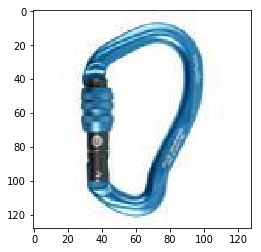

In [38]:
plt.imshow(imagesTestX[test_index])

In [39]:
print(imagesTestY[test_index])

carabiners


Test the service with single rest call

In [40]:
import requests
import json

# send a random row from the test set to score
input_data = "{\"data\": [" + str(list(imagesTestX[test_index].flatten())) + "]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("prediction:", resp.text)
print(resp)

prediction: "[\"carabiners\"]"
<Response [200]>
